In [153]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [154]:
df = web.DataReader('COALINDIA.NS', data_source='yahoo', start='2012-01-01', end='2022-04-18')
# df

In [176]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-02,313.200012,303.000000,303.000000,312.149994,3499615.0,142.259613
2012-01-03,329.750000,315.700012,315.700012,327.200012,6951091.0,149.118530
2012-01-04,330.799988,321.750000,327.899994,326.700012,3565108.0,148.890656
2012-01-05,327.950012,313.500000,324.000000,320.549988,6830098.0,146.087830
2012-01-06,322.799988,315.899994,315.899994,318.049988,2714233.0,144.948486
...,...,...,...,...,...,...
2022-04-08,198.800003,192.350006,194.699997,194.550003,20151959.0,194.550003
2022-04-11,198.000000,193.350006,194.500000,196.399994,12393619.0,196.399994
2022-04-12,195.750000,184.300003,195.750000,186.000000,18907630.0,186.000000


In [155]:
df.shape


(2536, 6)

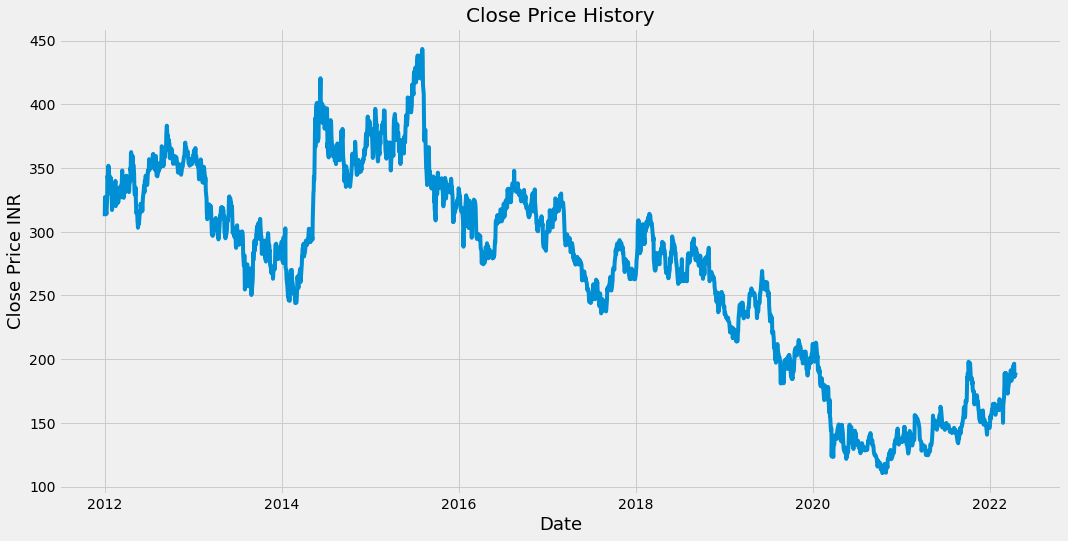

In [156]:
#visualise the closing price
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price INR', fontsize=18)
plt.show()

In [157]:
#Create a new dataframe with only close column
data = df.filter(['Close'])
dataset = data.values #converting to numpy array
#get the no of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

2029

In [158]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.60567822],
       [0.65089384],
       [0.64939166],
       ...,
       [0.22667868],
       [0.22848131],
       [0.2370437 ]])

In [159]:
#Create the training dataset
#Create the scaled training dataset

train_data = scaled_data[0: training_data_len, :]
#Split the data into X_train and Y_train data sets

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60 : i, 0 ])
    y_train.append(train_data[i, 0])
#     if i<= 60:
#         print(x_train)
#         print(y_train)
#         print()

In [160]:
#Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(1969, 60)

In [161]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) #(1345, 60, 1)
x_train.shape

(1969, 60, 1)

In [162]:
#Build the LSTM model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1))) #(60, 1)

model.add(LSTM(50, return_sequences=False, ))
model.add(Dense(25))
model.add(Dense(1))

In [163]:
#Compile the model

model.compile(optimizer='adam', loss='mean_squared_error')

In [164]:
#train the model

model.fit(x_train, y_train, batch_size=1, epochs=1)

1969/1969 [==============================] - 50s 24ms/step - loss: 0.0021


In [165]:
#Create the testing data set

#Create a new array containing scaled values from index 1345 to end

test_data = scaled_data[training_data_len - 60 : , :]

#create the datasets x_test and y_test

x_test = []
y_test = dataset[training_data_len: , :] #this will contain the actual values

for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60: i, 0])

In [166]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [167]:
#Reshape the datra
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [168]:
#get the models predicted price values

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) #we want predictions to contain the same values as y_test dataset



In [169]:
#Get the root mean squared error(RMSE)
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
rmse

2.7494705170099083

<ipython-input-170-e1db9ab83fe0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


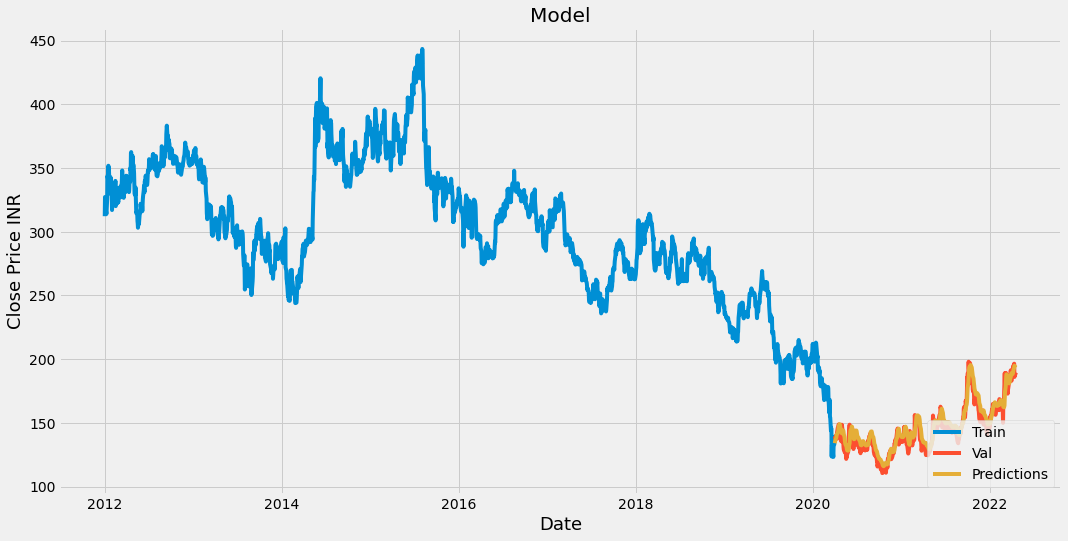

In [170]:
#Plot the data
train = data[0: training_data_len]
valid = data[training_data_len: ]
valid['Predictions'] = predictions

#Visulaize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price INR', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [172]:
#Show the valid and predicted prices

valid

,Close,Predictions
Date,,
2020-04-01,139.449997,134.001724
2020-04-03,137.750000,136.384277
2020-04-07,140.149994,138.265106
2020-04-08,137.350006,139.984589
2020-04-09,140.800003,140.928802
...,...,...
2022-04-08,194.550003,191.660919
2022-04-11,196.399994,193.125000
2022-04-12,186.000000,194.788239


In [173]:
#try and predict closing price at apr 20 2022
quote = web.DataReader('COALINDIA.NS', data_source='yahoo', start='2012-01-01', end='2022-04-19')
#create new dataframe

new_df = quote.filter(['Close'])

#get last 60day closing price values and convert the dataframe to an array
last_60_days = new_df[-60: ].values


#scale the data
last_60_days_scaled = scaler.transform(last_60_days)

x_test1 = []
x_test1.append(last_60_days_scaled)

#convert x_test to numpy array
x_test1 = np.array(x_test1)

#reshape
x_test1 = np.reshape(x_test1, (x_test1.shape[0], x_test1.shape[1], 1))
# print(x_test)

# print(x_test)
#get the predicted scaled price
pred_price = model.predict(x_test1)

#undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


[[193.85379]]


In [174]:
quote2 = web.DataReader('COALINDIA.NS', data_source='yahoo', start='2022-04-20', end='2022-04-20')
print(quote2['Close'])

Date
2022-04-20    199.100006
Name: Close, dtype: float64


In [143]:
dataa = web.DataReader('HINDALCO.NS', data_source='yahoo', start='2012-01-01', end='2022-04-19')

close = dataa.filter(['Close'])

#get last 60day closing price values and convert the dataframe to an array
last_60_days = close[-60: ].values

#scale the data
last_60_days_scaled = scaler.transform(last_60_days)

x_input = []
x_input.append(last_60_days_scaled)

#convert x_input to numpy array
x_input = np.array(x_input)

#reshape

x_input = np.reshape(x_input, (x_input.shape[0], x_input.shape[1], 1))

pred_price = model.predict(x_input)

#undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)
# print(x_input.shape)
    
# temp_input=list(x_input)

# temp_input=temp_input[0].tolist()
# print(x_input)
# print(temp_input)

[[510.59262]]


In [136]:
close2 = close.tail(60)


In [137]:
# x_test

In [138]:
from numpy import array

lst_output=[]
n_steps=60
i=0
while(i<30):
    
    if(len(temp_input)>60):
        x_input=np.array(temp_input[1:], dtype=object).astype("float32")
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
#         print(x_input)
#         print(yhat)
        temp_input.append(yhat[0].tolist())
        temp_input=temp_input[1:]
        
        #print(temp_input)
        
        lst_output.append(yhat[0].tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
#         print(x_input)
#         print(yhat)
        temp_input.append(yhat[0].tolist())
        lst_output.append(yhat[0].tolist())
        i=i+1

In [139]:
lst_output

[[0.7974764704704285],
 [0.7805267572402954],
 [0.7615103125572205],
 [0.7418338656425476],
 [0.7221730947494507],
 [0.7028650641441345],
 [0.6840831637382507],
 [0.665917158126831],
 [0.6484094858169556],
 [0.6315742135047913],
 [0.6154074668884277],
 [0.5998932719230652],
 [0.5850076675415039],
 [0.5707221627235413],
 [0.5570055246353149],
 [0.5438255071640015],
 [0.5311499238014221],
 [0.5189480781555176],
 [0.5071906447410583],
 [0.49585047364234924],
 [0.48490262031555176],
 [0.47432416677474976],
 [0.4640945792198181],
 [0.45419546961784363],
 [0.4446103572845459],
 [0.4353242516517639],
 [0.4263239800930023],
 [0.4175977110862732],
 [0.4091346263885498],
 [0.4009249210357666]]

In [140]:
lst_output = scaler.inverse_transform(lst_output)

In [141]:
print(lst_output)

[[515.78056933]
 [506.11245314]
 [495.26547335]
 [484.0420283 ]
 [472.82752485]
 [461.81422446]
 [451.10102873]
 [440.73913938]
 [430.75276333]
 [421.14992424]
 [411.92841219]
 [403.07911559]
 [394.58836706]
 [386.43991531]
 [378.61594513]
 [371.09806334]
 [363.86791077]
 [356.90797818]
 [350.20153832]
 [343.73310488]
 [337.48844949]
 [331.45449974]
 [325.61954314]
 [319.97309116]
 [314.50574322]
 [309.20894869]
 [304.07519392]
 [299.09773019]
 [294.2703868 ]
 [289.58757098]]


In [92]:
listtt

NameError: name 'listtt' is not defined

In [280]:
#Plot the data
# train = data[0: training_data_len]
# valid = data[training_data_len: ]
# valid['Predictions'] = predictions
# close2['next'] = lst_output

# #Visulaize the data
# plt.figure(figsize=(20,8))
# plt.title('Model')
# plt.xlabel('Date', fontsize = 18)
# plt.ylabel('Close Price INR', fontsize=18)
# plt.plot(train['Close'])
# plt.plot(valid[['Close','Predictions']])
# plt.plot(close2['next'])

# plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
# plt.show()

In [93]:
dataa2 = web.DataReader('HINDUNILVR.NS', data_source='yahoo', start='2012-01-01', end='2022-04-18')
dataa2 = dataa2['Close'][-100:]
dataa2 = dataa2.tolist()

In [270]:
list1 = dataa2 + lst_output


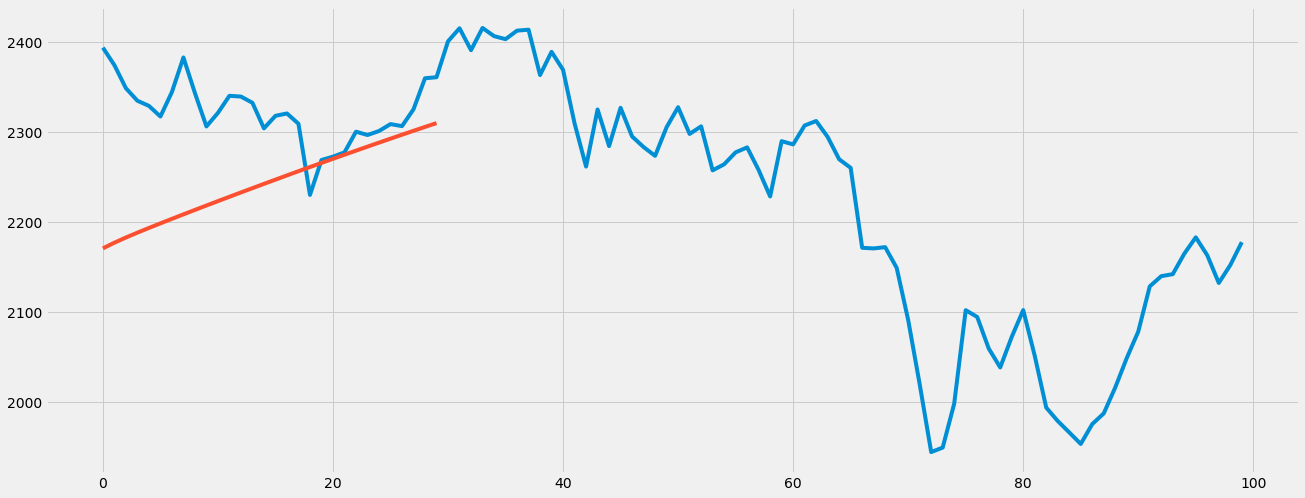

In [94]:
plt.figure(figsize=(20, 8))
plt.plot(dataa2)
plt.plot(lst_output)
plt.show()

[233.22548355627305]

In [4]:
# quote5 = web.DataReader('ITC.NS', data_source='yahoo', start='2022-01-10', end='2022-04-10')
# #create new dataframe

# new_df = quote5.filter(['Close'])

# #get last 60day closing price values and convert the dataframe to an array
# last_60_days = new_df[-60: ].values

# #scale the data
# last_60_days_scaled = scaler.transform(last_60_days)

# x_test = []
# x_test.append(last_60_days_scaled)

# #convert x_test to numpy array
# x_test = np.array(x_test)
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
# # x_test
# temp_input=list(x_test)
# temp_input=temp_input[0].tolist()
# temp_input = temp_input[0].values
# tenp_input

In [5]:
# from numpy import array

# lst_output=[]
# n_steps=60
# i=0
# while(i<30):
    
#     if(len(temp_input)>60):
#         #print(temp_input)
#         x_test=np.array(temp_input[1:])
# #         print("{} day input {}".format(i,x_input))
#         x_test=x_test.reshape(1,-1)
#         x_test = x_test.reshape((1, n_steps, 1))
#         #print(x_input)
#         yhat = model.predict(x_test, verbose=0)
# #         print("{} day output {}".format(i,yhat))
#         temp_input.extend(yhat[0].tolist())
#         temp_input=temp_input[1:]
#         #print(temp_input)
#         lst_output.extend(yhat.tolist())
#         i=i+1
#     else:
#         x_test = x_test.reshape((1, n_steps,1))
#         yhat = model.predict(x_test, verbose=0)
#         print(yhat[0])
#         temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
#         lst_output.extend(yhat.tolist())
#         i=i+1